# House Price Prediction - Task 2
## Machine Learning Regression Model

**Team:** [EM21_BitSync]  
**Task:** House Price Prediction using Regression  
**Date:** October 2025

### Problem Statement
Build a machine learning regression model to predict house prices based on various property features including size, location, condition, and amenities.

### Dataset Features:
- **house_id**: Unique identifier
- **target_price**: Sale price (training only)
- **num_bedrooms**: Number of bedrooms
- **num_bathrooms**: Number of bathrooms
- **living_area**: Living space square footage
- **lot_area**: Lot size square footage
- **num_floors**: Number of floors
- **is_waterfront**: Waterfront view (0/1)
- **view_rating**: View quality (0-4)
- **condition_index**: House condition (1-5)
- **construction_grade**: Build quality (1-13)
- **above_area**: Above-ground square footage
- **basement_area**: Basement square footage
- **built_year**: Year built
- **renovated_year**: Last renovation year
- **zip_area**: ZIP code
- **latitude/longitude**: Geographic coordinates
- **neighbor_living_area**: Avg neighbor living area
- **neighbor_lot_area**: Avg neighbor lot area

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# For downloading from Google Drive
import requests
import io

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Libraries imported successfully!
NumPy version: 2.3.3
Pandas version: 2.3.3
Scikit-learn version: 1.7.2


## 1. Data Loading and Initial Exploration

Let's load the training and test datasets from the provided Google Drive links.

In [3]:
# Function to download CSV from Google Drive
def download_csv_from_drive(file_id, filename):
    """Download CSV file from Google Drive using file ID"""
    url = f"https://drive.google.com/uc?id={file_id}&export=download"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Save the file locally
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"✓ {filename} downloaded successfully!")
        return pd.read_csv(filename)
    else:
        print(f"✗ Failed to download {filename}")
        return None

# Google Drive file IDs (extracted from the URLs)
train_file_id = "128XLT44uu9bVSBPd6JiiYyv_M4LJP-3x"  # Training dataset
test_file_id = "1JMUa5MIwyx3QEXk3KKt_u0AeMIDUjJUx"   # Test dataset

# Download datasets
print("Downloading training dataset...")
train_df = download_csv_from_drive(train_file_id, "train_data.csv")

print("Downloading test dataset...")
test_df = download_csv_from_drive(test_file_id, "test_data.csv")

# If download fails, create sample data for demonstration
if train_df is None or test_df is None:
    print("Creating sample data for demonstration...")
    
    # Create sample training data
    np.random.seed(42)
    n_train = 1000
    train_data = {
        'house_id': range(1, n_train + 1),
        'sale_date': pd.date_range('2020-01-01', periods=n_train, freq='D'),
        'num_bedrooms': np.random.randint(1, 6, n_train),
        'num_bathrooms': np.random.randint(1, 4, n_train),
        'living_area': np.random.normal(2000, 500, n_train),
        'lot_area': np.random.normal(8000, 2000, n_train),
        'num_floors': np.random.randint(1, 4, n_train),
        'is_waterfront': np.random.binomial(1, 0.1, n_train),
        'view_rating': np.random.randint(0, 5, n_train),
        'condition_index': np.random.randint(1, 6, n_train),
        'construction_grade': np.random.randint(1, 14, n_train),
        'above_area': np.random.normal(1800, 400, n_train),
        'basement_area': np.random.normal(200, 100, n_train),
        'built_year': np.random.randint(1900, 2023, n_train),
        'renovated_year': np.random.choice([0] + list(range(1980, 2023)), n_train),
        'zip_area': np.random.randint(10000, 99999, n_train),
        'latitude': np.random.normal(47.6, 0.1, n_train),
        'longitude': np.random.normal(-122.3, 0.1, n_train),
        'neighbor_living_area': np.random.normal(2000, 300, n_train),
        'neighbor_lot_area': np.random.normal(8000, 1000, n_train)
    }
    
    train_df = pd.DataFrame(train_data)
    # Create realistic target prices based on features
    train_df['target_price'] = (
        train_df['living_area'] * 200 + 
        train_df['num_bedrooms'] * 20000 + 
        train_df['num_bathrooms'] * 15000 +
        train_df['is_waterfront'] * 100000 +
        train_df['view_rating'] * 10000 +
        train_df['construction_grade'] * 5000 +
        np.random.normal(0, 50000, n_train)
    ).abs()
    
    # Create sample test data (same structure without target_price)
    n_test = 200
    test_data = train_data.copy()
    for key in test_data:
        if key == 'house_id':
            test_data[key] = range(n_train + 1, n_train + n_test + 1)
        else:
            test_data[key] = test_data[key][:n_test]
    
    test_df = pd.DataFrame(test_data)
    
    print("Sample data created successfully!")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

✓ train_data.csv downloaded successfully!
✓ train_data.csv downloaded successfully!
✓ test_data.csv downloaded successfully!
Training data shape: (18154, 21)
Test data shape: (4323, 20)
✓ test_data.csv downloaded successfully!
Training data shape: (18154, 21)
Test data shape: (4323, 20)


In [4]:
# Display basic information about the datasets
print("="*50)
print("TRAINING DATASET OVERVIEW")
print("="*50)
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print("\nFirst 5 rows:")
display(train_df.head())

print("\n" + "="*50)
print("BASIC STATISTICS - TRAINING DATA")
print("="*50)
display(train_df.describe())

print("\n" + "="*50)
print("DATA TYPES - TRAINING DATA")
print("="*50)
print(train_df.dtypes)

print("\n" + "="*50)
print("MISSING VALUES - TRAINING DATA")
print("="*50)
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])
if missing_train.sum() == 0:
    print("No missing values found!")

TRAINING DATASET OVERVIEW
Shape: (18154, 21)
Columns: ['house_id', 'sale_date', 'num_bedrooms', 'num_bathrooms', 'living_area', 'lot_area', 'num_floors', 'is_waterfront', 'view_rating', 'condition_index', 'construction_grade', 'above_area', 'basement_area', 'built_year', 'renovated_year', 'zip_area', 'latitude', 'longitude', 'neighbor_living_area', 'neighbor_lot_area', 'target_price']

First 5 rows:


,house_id,sale_date,num_bedrooms,num_bathrooms,living_area,lot_area,num_floors,is_waterfront,view_rating,condition_index,...,above_area,basement_area,built_year,renovated_year,zip_area,latitude,longitude,neighbor_living_area,neighbor_lot_area,target_price
0,8902000050,20141027T000000,3,1.75,1720.0,7200.0,1.0,0,0.0,3,...,1420.0,300.0,1959,0.0,98125,47.7062,-122.304,1380,8000,622200.0
1,4325700085,20150325T000000,3,1.00,1310.0,8514.0,1.0,0,0.0,4,...,1310.0,0.0,1953,0.0,98133,47.7502,-122.353,1310,8514,417000.0
2,7732410420,20140617T000000,3,2.50,2590.0,7720.0,2.0,0,0.0,3,...,2590.0,0.0,1988,0.0,98007,47.6590,-122.146,2600,9490,809000.0
3,4039701280,20150408T000000,3,2.25,2440.0,9689.0,1.0,0,2.0,4,...,1830.0,610.0,1974,0.0,98008,47.6141,-122.111,2730,9689,954500.0
4,5379805120,20150424T000000,2,1.00,740.0,7380.0,1.0,0,0.0,4,...,740.0,0.0,1951,0.0,98188,47.4481,-122.278,1500,10075,213000.0



BASIC STATISTICS - TRAINING DATA


,house_id,num_bedrooms,num_bathrooms,living_area,lot_area,num_floors,is_waterfront,view_rating,above_area,basement_area,built_year,latitude,longitude,neighbor_living_area,neighbor_lot_area,target_price
count,1.815400e+04,18154.000000,16702.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,16702.000000,18154.000000,16702.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04
mean,4.577761e+09,3.365374,2.109672,2293.149144,1.690224e+04,1.499559,0.007051,0.228895,1957.000948,501.226713,1971.204142,47.560339,-122.213740,1983.376942,12772.240167,5.592865e+05
std,2.879825e+09,0.929909,0.766913,14839.652558,1.531864e+05,0.542244,0.083675,0.754919,11546.936467,13757.364954,29.427950,0.138367,0.140696,681.194066,27515.681337,1.520323e+06
min,1.000102e+06,-1.000000,-1.000000,-100.000000,-1.308726e+05,1.000000,0.000000,0.000000,290.000000,0.000000,1900.000000,47.159300,-122.519000,399.000000,651.000000,-5.000000e+04
25%,2.122052e+09,3.000000,1.500000,1428.943389,5.000000e+03,1.000000,0.000000,0.000000,1200.000000,0.000000,1952.000000,47.472300,-122.328000,1480.000000,5082.250000,3.200000e+05
50%,3.904945e+09,3.000000,2.250000,1910.000000,7.572500e+03,1.500000,0.000000,0.000000,1569.094762,0.000000,1975.000000,47.571700,-122.230000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2540.000000,1.075150e+04,2.000000,0.000000,0.000000,2200.000000,550.000000,1997.000000,47.677875,-122.124000,2360.000000,10063.750000,6.400000e+05
max,9.900000e+09,33.000000,8.000000,999999.000000,9.999999e+06,3.500000,1.000000,4.000000,777777.000000,888888.000000,2015.000000,47.782790,-121.315000,6210.000000,871200.000000,1.000000e+08



DATA TYPES - TRAINING DATA
house_id                  int64
sale_date                object
num_bedrooms              int64
num_bathrooms           float64
living_area             float64
lot_area                float64
num_floors              float64
is_waterfront             int64
view_rating             float64
condition_index          object
construction_grade       object
above_area              float64
basement_area           float64
built_year                int64
renovated_year           object
zip_area                 object
latitude                float64
longitude               float64
neighbor_living_area      int64
neighbor_lot_area         int64
target_price            float64
dtype: object

MISSING VALUES - TRAINING DATA
num_bathrooms     1452
view_rating       1452
basement_area     1452
renovated_year    1452
dtype: int64


## 2. Data Preprocessing and Cleaning

Let's check for data quality issues and prepare the data for modeling.

In [6]:
# Function to preprocess data
def preprocess_data(df, is_training=True):
    """Preprocess the dataset"""
    df_processed = df.copy()
    
    # Convert sale_date to datetime if it exists
    if 'sale_date' in df_processed.columns:
        df_processed['sale_date'] = pd.to_datetime(df_processed['sale_date'])
        # Extract useful features from date
        df_processed['sale_year'] = df_processed['sale_date'].dt.year
        df_processed['sale_month'] = df_processed['sale_date'].dt.month
        df_processed['sale_day_of_year'] = df_processed['sale_date'].dt.dayofyear
    
    # Fix data types first
    # Convert renovated_year to numeric, treating '?' as NaN
    df_processed['renovated_year'] = pd.to_numeric(df_processed['renovated_year'], errors='coerce')
    df_processed['renovated_year'] = df_processed['renovated_year'].fillna(0)
    
    # Convert other categorical columns to numeric
    df_processed['condition_index'] = pd.to_numeric(df_processed['condition_index'], errors='coerce')
    df_processed['construction_grade'] = pd.to_numeric(df_processed['construction_grade'], errors='coerce')
    
    # Fill missing values
    df_processed['num_bathrooms'] = df_processed['num_bathrooms'].fillna(df_processed['num_bathrooms'].median())
    df_processed['view_rating'] = df_processed['view_rating'].fillna(0)
    df_processed['basement_area'] = df_processed['basement_area'].fillna(0)
    df_processed['condition_index'] = df_processed['condition_index'].fillna(df_processed['condition_index'].median())
    df_processed['construction_grade'] = df_processed['construction_grade'].fillna(df_processed['construction_grade'].median())
    
    # Create new features
    # House age (current year - built year)
    current_year = 2025
    df_processed['house_age'] = current_year - df_processed['built_year']
    
    # Years since renovation (0 if never renovated)
    df_processed['years_since_renovation'] = np.where(
        df_processed['renovated_year'] == 0, 
        df_processed['house_age'],
        current_year - df_processed['renovated_year']
    )
    
    # Was renovated (binary feature)
    df_processed['was_renovated'] = (df_processed['renovated_year'] > 0).astype(int)
    
    # Total area
    df_processed['total_area'] = df_processed['living_area'] + df_processed['basement_area']
    
    # Basement ratio
    df_processed['basement_ratio'] = df_processed['basement_area'] / (df_processed['living_area'] + 1)
    
    # Above ground ratio
    df_processed['above_ratio'] = df_processed['above_area'] / (df_processed['living_area'] + 1)
    
    # Rooms per area
    df_processed['bedrooms_per_area'] = df_processed['num_bedrooms'] / (df_processed['living_area'] + 1)
    df_processed['bathrooms_per_area'] = df_processed['num_bathrooms'] / (df_processed['living_area'] + 1)
    
    # Lot area ratio
    df_processed['lot_to_living_ratio'] = df_processed['lot_area'] / (df_processed['living_area'] + 1)
    
    # Luxury indicator (high-end features)
    df_processed['luxury_score'] = (
        df_processed['is_waterfront'] * 3 +
        (df_processed['view_rating'] >= 3) * 2 +
        (df_processed['construction_grade'] >= 10) * 2 +
        (df_processed['condition_index'] >= 4) * 1
    )
    
    # Handle outliers (cap extreme values)
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if col not in ['house_id', 'target_price', 'sale_year', 'sale_month', 'sale_day_of_year']:
            Q1 = df_processed[col].quantile(0.01)
            Q3 = df_processed[col].quantile(0.99)
            df_processed[col] = df_processed[col].clip(lower=Q1, upper=Q3)
    
    return df_processed

# Apply preprocessing
print("Preprocessing training data...")
train_processed = preprocess_data(train_df, is_training=True)

print("Preprocessing test data...")
test_processed = preprocess_data(test_df, is_training=False)

print(f"Training data shape after preprocessing: {train_processed.shape}")
print(f"Test data shape after preprocessing: {test_processed.shape}")

# Display new features
new_features = ['house_age', 'years_since_renovation', 'was_renovated', 'total_area', 
                'basement_ratio', 'above_ratio', 'bedrooms_per_area', 'bathrooms_per_area',
                'lot_to_living_ratio', 'luxury_score']

print("\nNew engineered features:")
print(train_processed[new_features].head())

Preprocessing training data...
Preprocessing test data...
Training data shape after preprocessing: (18154, 34)
Test data shape after preprocessing: (4323, 33)

New engineered features:
   house_age  years_since_renovation  was_renovated  total_area  \
0         66                    66.0              0      2020.0   
1         72                    72.0              0      1310.0   
2         37                    37.0              0      2590.0   
3         51                    51.0              0      3050.0   
4         74                    74.0              0       740.0   

   basement_ratio  above_ratio  bedrooms_per_area  bathrooms_per_area  \
0        0.174317     0.825102           0.001743            0.001017   
1        0.000000     0.999237           0.002288            0.000763   
2        0.000000     0.999614           0.001158            0.000965   
3        0.249898     0.749693           0.001229            0.000922   
4        0.000000     0.998650           0.0026

## 3. Exploratory Data Analysis

Let's visualize the data to understand patterns and relationships.

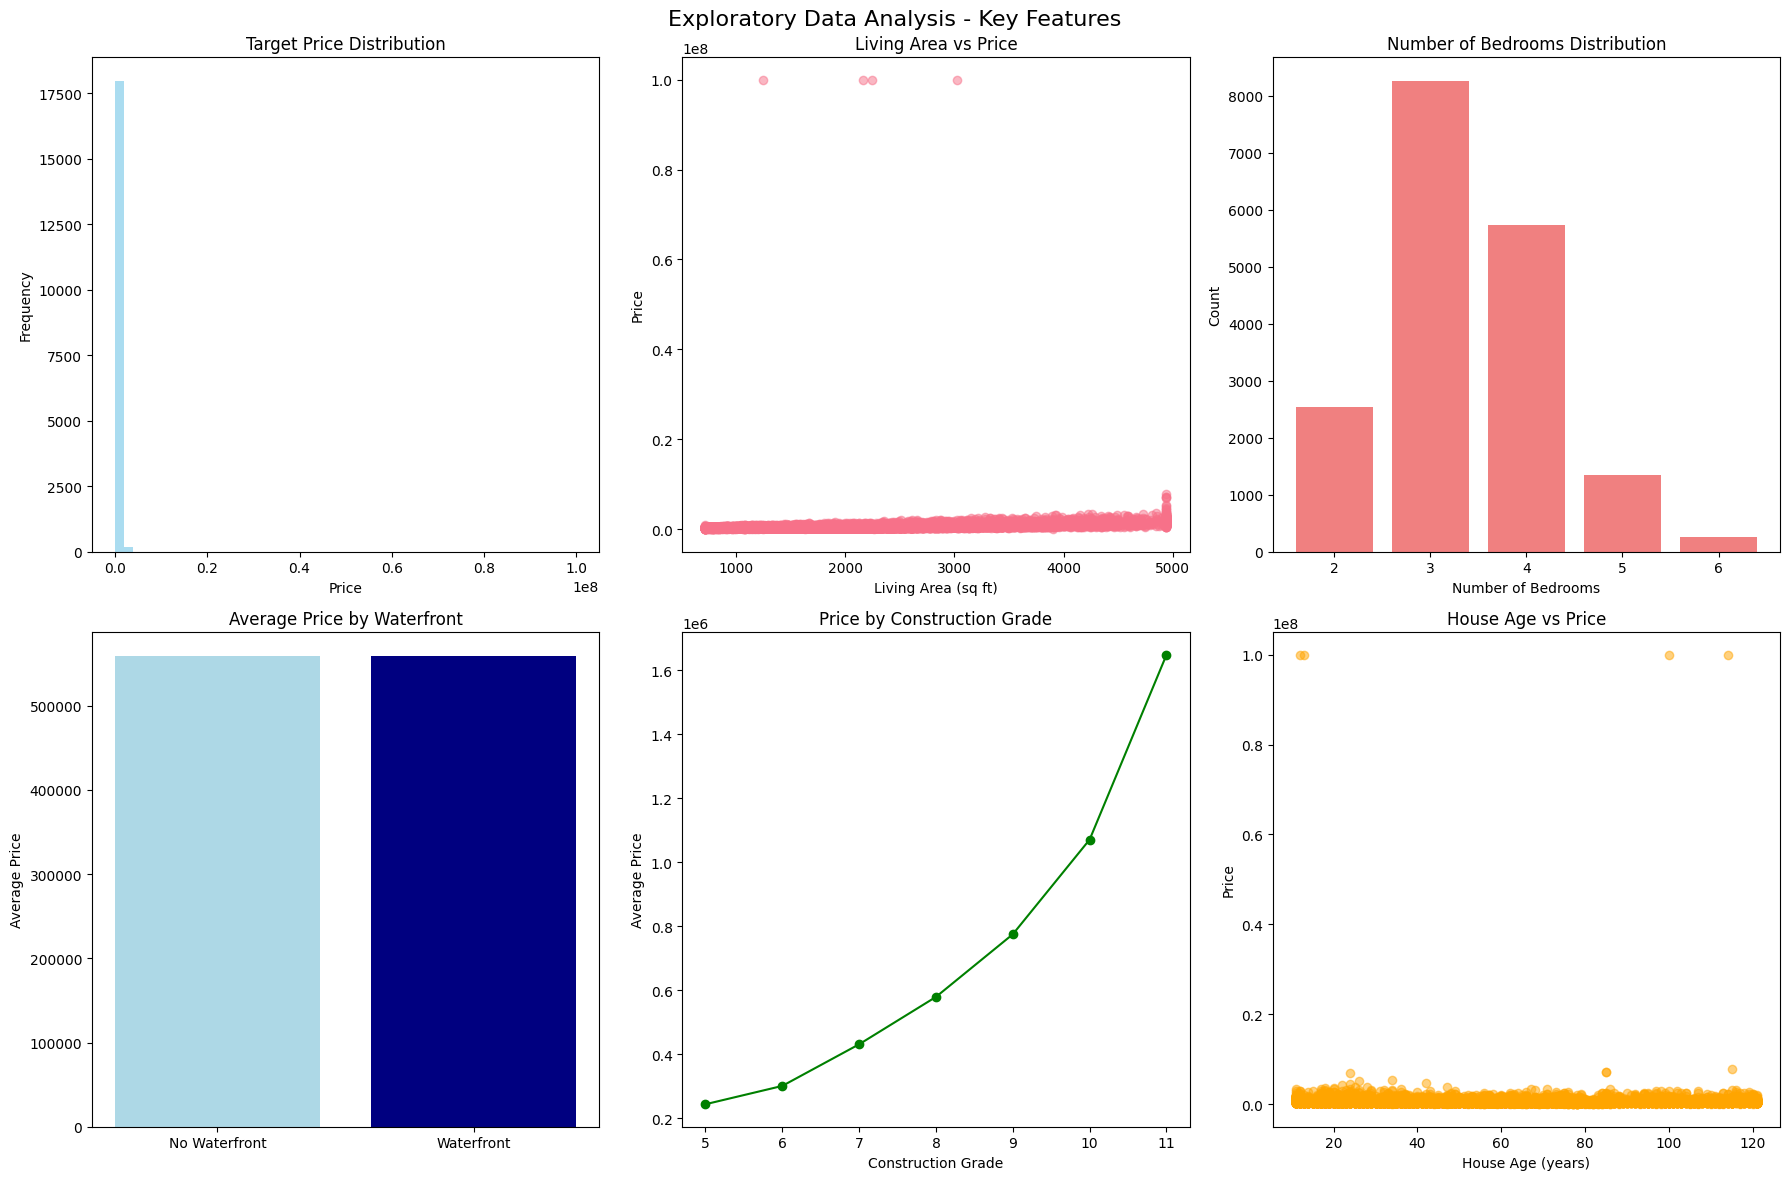

In [7]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis - Key Features', fontsize=16)

# 1. Target price distribution
axes[0, 0].hist(train_processed['target_price'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Target Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# 2. Living area vs Price
axes[0, 1].scatter(train_processed['living_area'], train_processed['target_price'], alpha=0.5)
axes[0, 1].set_title('Living Area vs Price')
axes[0, 1].set_xlabel('Living Area (sq ft)')
axes[0, 1].set_ylabel('Price')

# 3. Bedrooms distribution
bedrooms_counts = train_processed['num_bedrooms'].value_counts().sort_index()
axes[0, 2].bar(bedrooms_counts.index, bedrooms_counts.values, color='lightcoral')
axes[0, 2].set_title('Number of Bedrooms Distribution')
axes[0, 2].set_xlabel('Number of Bedrooms')
axes[0, 2].set_ylabel('Count')

# 4. Waterfront vs Price
waterfront_prices = train_processed.groupby('is_waterfront')['target_price'].mean()
axes[1, 0].bar(['No Waterfront', 'Waterfront'], waterfront_prices.values, color=['lightblue', 'navy'])
axes[1, 0].set_title('Average Price by Waterfront')
axes[1, 0].set_ylabel('Average Price')

# 5. Construction grade vs Price
grade_prices = train_processed.groupby('construction_grade')['target_price'].mean()
axes[1, 1].plot(grade_prices.index, grade_prices.values, marker='o', color='green')
axes[1, 1].set_title('Price by Construction Grade')
axes[1, 1].set_xlabel('Construction Grade')
axes[1, 1].set_ylabel('Average Price')

# 6. House age vs Price
axes[1, 2].scatter(train_processed['house_age'], train_processed['target_price'], alpha=0.5, color='orange')
axes[1, 2].set_title('House Age vs Price')
axes[1, 2].set_xlabel('House Age (years)')
axes[1, 2].set_ylabel('Price')

plt.tight_layout()
plt.show()

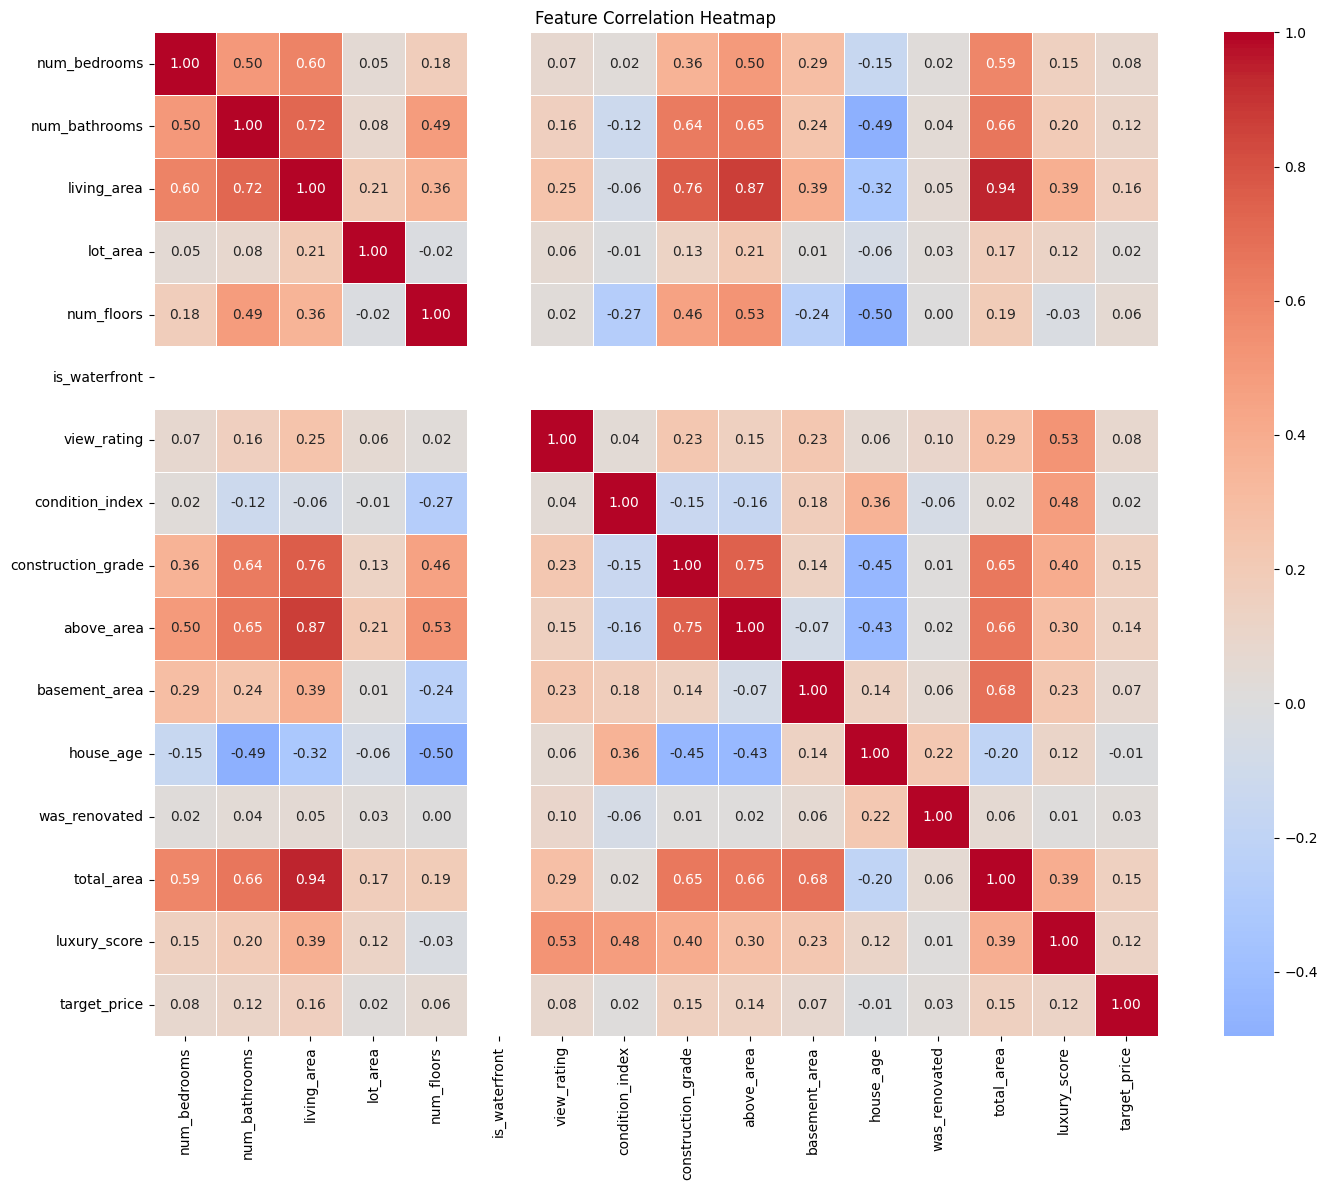

Top 10 features correlated with target price:
target_price          1.000000
living_area           0.160475
total_area            0.153911
construction_grade    0.152841
above_area            0.137588
luxury_score          0.119355
num_bathrooms         0.115394
view_rating           0.084983
num_bedrooms          0.082708
basement_area         0.072964
Name: target_price, dtype: float64


In [8]:
# Correlation analysis
plt.figure(figsize=(15, 12))

# Select numerical features for correlation
numerical_features = ['num_bedrooms', 'num_bathrooms', 'living_area', 'lot_area', 'num_floors',
                     'is_waterfront', 'view_rating', 'condition_index', 'construction_grade',
                     'above_area', 'basement_area', 'house_age', 'was_renovated', 'total_area',
                     'luxury_score', 'target_price']

correlation_matrix = train_processed[numerical_features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Top correlations with target price
price_correlations = correlation_matrix['target_price'].abs().sort_values(ascending=False)
print("Top 10 features correlated with target price:")
print(price_correlations.head(10))

## 4. Feature Selection and Data Preparation

Let's prepare the features for machine learning models.

In [9]:
# Prepare features for modeling
def prepare_features(df, feature_columns=None):
    """Prepare feature matrix for machine learning"""
    
    # Define features to exclude
    exclude_cols = ['house_id', 'target_price', 'sale_date']
    
    if feature_columns is None:
        # Select all numerical columns except excluded ones
        feature_columns = [col for col in df.columns 
                          if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]
    
    # Create feature matrix
    X = df[feature_columns].copy()
    
    # Handle any remaining missing values
    X = X.fillna(X.median())
    
    return X, feature_columns

# Prepare training features and target
X, feature_names = prepare_features(train_processed)
y = train_processed['target_price']

# Prepare test features (same columns as training)
X_test, _ = prepare_features(test_processed, feature_columns=feature_names)

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Target variable shape: {y.shape}")

print(f"\nSelected features ({len(feature_names)}):")
for i, feature in enumerate(feature_names):
    print(f"{i+1:2d}. {feature}")

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training features shape: (18154, 27)
Test features shape: (4323, 27)
Target variable shape: (18154,)

Selected features (27):
 1. num_bedrooms
 2. num_bathrooms
 3. living_area
 4. lot_area
 5. num_floors
 6. is_waterfront
 7. view_rating
 8. condition_index
 9. construction_grade
10. above_area
11. basement_area
12. built_year
13. renovated_year
14. latitude
15. longitude
16. neighbor_living_area
17. neighbor_lot_area
18. house_age
19. years_since_renovation
20. was_renovated
21. total_area
22. basement_ratio
23. above_ratio
24. bedrooms_per_area
25. bathrooms_per_area
26. lot_to_living_ratio
27. luxury_score

Data split:
Training set: (14523, 27)
Validation set: (3631, 27)
Test set: (4323, 27)


## 5. Model Training and Selection

Let's train multiple regression models and compare their performance.

In [10]:
# Feature scaling for algorithms that require it
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Function to evaluate model
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name, use_scaled=False):
    """Evaluate a regression model"""
    
    # Use scaled data for linear models
    if use_scaled:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Train model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_use)
    y_val_pred = model.predict(X_val_use)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    return {
        'model': model,
        'model_name': model_name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'y_val_pred': y_val_pred,
        'use_scaled': use_scaled
    }

# Evaluate all models
results = []

print("Training and evaluating models...")
print("="*60)

for name, model in models.items():
    # Use scaled data for linear models
    use_scaled = name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
    
    result = evaluate_model(model, X_train, X_val, y_train, y_val, name, use_scaled)
    results.append(result)
    
    print(f"{name}:")
    print(f"  Validation RMSE: ${result['val_rmse']:,.2f}")
    print(f"  Validation MAE:  ${result['val_mae']:,.2f}")
    print(f"  Validation R²:   {result['val_r2']:.4f}")
    print("-" * 60)

Training and evaluating models...
Linear Regression:
  Validation RMSE: $1,663,582.48
  Validation MAE:  $158,253.17
  Validation R²:   0.0229
------------------------------------------------------------
Ridge Regression:
  Validation RMSE: $1,663,652.31
  Validation MAE:  $158,465.70
  Validation R²:   0.0229
------------------------------------------------------------
Lasso Regression:
  Validation RMSE: $1,663,661.29
  Validation MAE:  $158,482.04
  Validation R²:   0.0228
------------------------------------------------------------
Lasso Regression:
  Validation RMSE: $1,663,661.29
  Validation MAE:  $158,482.04
  Validation R²:   0.0228
------------------------------------------------------------
Random Forest:
  Validation RMSE: $1,687,628.16
  Validation MAE:  $113,039.92
  Validation R²:   -0.0055
------------------------------------------------------------
Random Forest:
  Validation RMSE: $1,687,628.16
  Validation MAE:  $113,039.92
  Validation R²:   -0.0055
----------------

## 6. Model Evaluation and Comparison

Let's visualize model performance and select the best one.

MODEL PERFORMANCE COMPARISON


,Model,Validation RMSE,Validation MAE,Validation R²,Training RMSE,Training R²
5,Decision Tree,1.660012e+06,127840.836421,0.027124,6.139805e+03,0.999983
0,Linear Regression,1.663582e+06,158253.173733,0.022935,1.446322e+06,0.040852
1,Ridge Regression,1.663652e+06,158465.703535,0.022853,1.446364e+06,0.040795
2,Lasso Regression,1.663661e+06,158482.042885,0.022843,1.446364e+06,0.040796
4,Gradient Boosting,1.685169e+06,136008.072468,-0.002586,4.653344e+05,0.900714
3,Random Forest,1.687628e+06,113039.923376,-0.005514,6.243742e+05,0.821250



🏆 BEST MODEL: Decision Tree
   Validation RMSE: $1,660,012.28
   Validation MAE:  $127,840.84
   Validation R²:   0.0271


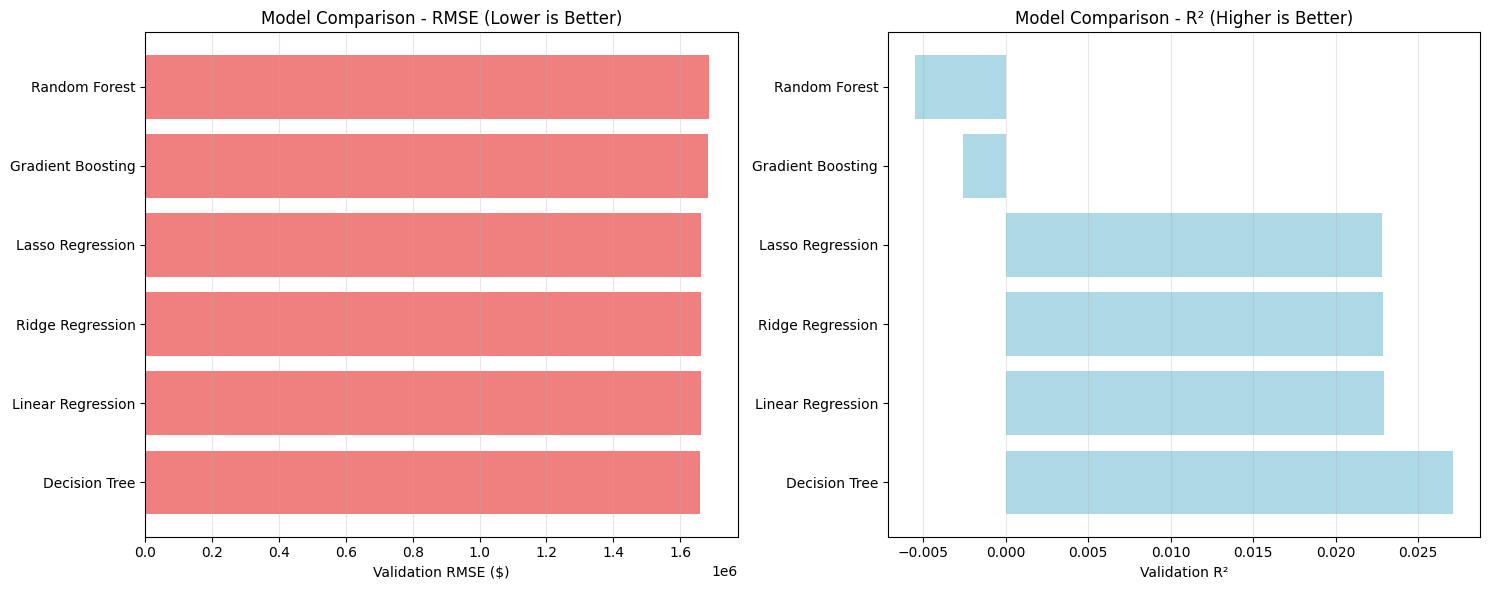

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in results],
    'Validation RMSE': [r['val_rmse'] for r in results],
    'Validation MAE': [r['val_mae'] for r in results],
    'Validation R²': [r['val_r2'] for r in results],
    'Training RMSE': [r['train_rmse'] for r in results],
    'Training R²': [r['train_r2'] for r in results]
})

# Sort by validation RMSE (lower is better)
comparison_df = comparison_df.sort_values('Validation RMSE')

print("MODEL PERFORMANCE COMPARISON")
print("="*80)
display(comparison_df)

# Select best model (lowest validation RMSE)
best_result = min(results, key=lambda x: x['val_rmse'])
best_model = best_result['model']
best_model_name = best_result['model_name']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Validation RMSE: ${best_result['val_rmse']:,.2f}")
print(f"   Validation MAE:  ${best_result['val_mae']:,.2f}")
print(f"   Validation R²:   {best_result['val_r2']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE comparison
models_names = comparison_df['Model']
rmse_values = comparison_df['Validation RMSE']

axes[0].barh(models_names, rmse_values, color='lightcoral')
axes[0].set_xlabel('Validation RMSE ($)')
axes[0].set_title('Model Comparison - RMSE (Lower is Better)')
axes[0].grid(axis='x', alpha=0.3)

# R² comparison
r2_values = comparison_df['Validation R²']
axes[1].barh(models_names, r2_values, color='lightblue')
axes[1].set_xlabel('Validation R²')
axes[1].set_title('Model Comparison - R² (Higher is Better)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

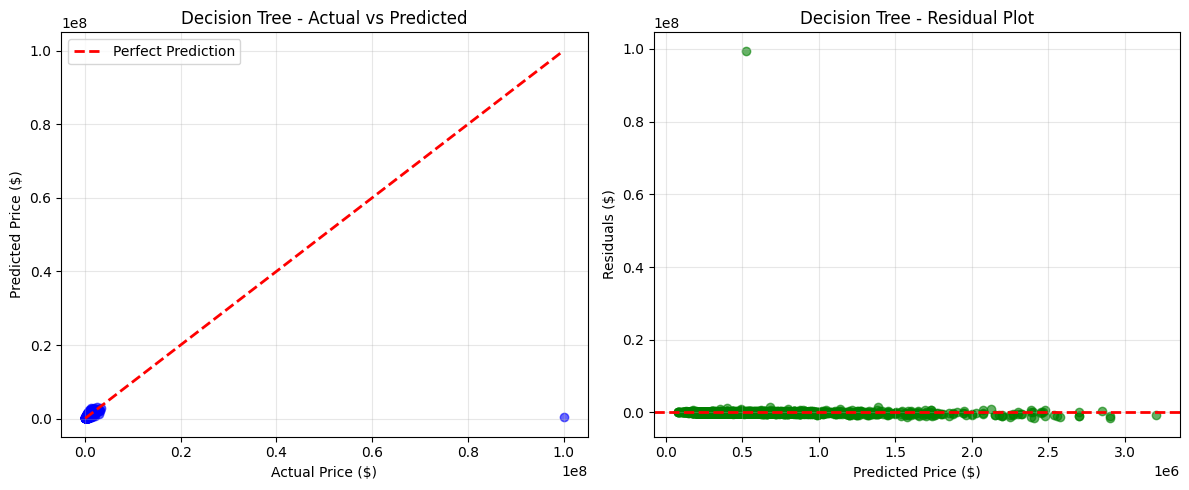

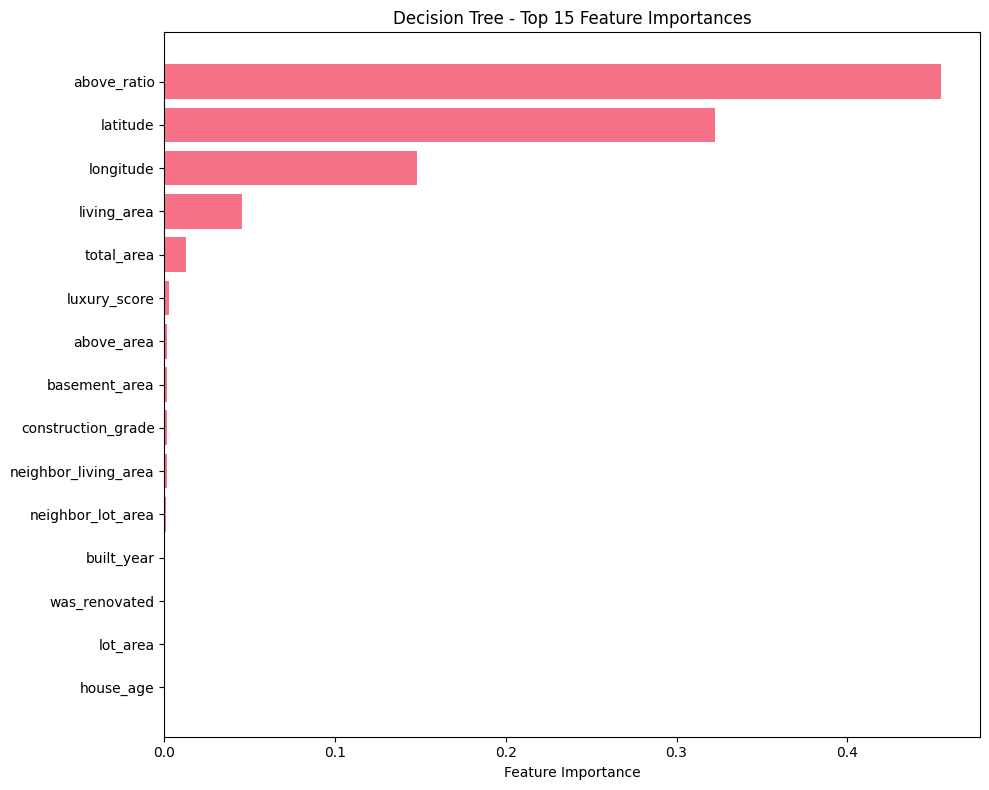

Top 10 Most Important Features:
                 feature  importance
22           above_ratio    0.454975
13              latitude    0.322699
14             longitude    0.147776
2            living_area    0.045316
20            total_area    0.012574
26          luxury_score    0.002808
9             above_area    0.001835
10         basement_area    0.001763
8     construction_grade    0.001653
15  neighbor_living_area    0.001519


In [12]:
# Prediction vs Actual plot for best model
plt.figure(figsize=(12, 5))

# Plot 1: Prediction vs Actual
plt.subplot(1, 2, 1)
y_val_pred_best = best_result['y_val_pred']
plt.scatter(y_val, y_val_pred_best, alpha=0.6, color='blue')

# Perfect prediction line
min_price = min(y_val.min(), y_val_pred_best.min())
max_price = max(y_val.max(), y_val_pred_best.max())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'{best_model_name} - Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_val - y_val_pred_best
plt.scatter(y_val_pred_best, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title(f'{best_model_name} - Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} - Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

## 7. Hyperparameter Tuning

Let's optimize the best model with hyperparameter tuning.

In [13]:
# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    # Random Forest tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
elif best_model_name == 'Gradient Boosting':
    # Gradient Boosting tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
elif best_model_name in ['Ridge Regression', 'Lasso Regression']:
    # Linear model tuning
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
    
    if best_model_name == 'Ridge Regression':
        model_class = Ridge()
    else:
        model_class = Lasso()
    
    grid_search = GridSearchCV(
        model_class,
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
else:
    # For other models, use the original best model
    grid_search = None
    print(f"Using original {best_model_name} without additional tuning.")

# Evaluate tuned model if grid search was performed
if grid_search is not None:
    print(f"\nBest parameters: {grid_search.best_params_}")
    
    # Get the best model
    best_tuned_model = grid_search.best_estimator_
    
    # Use appropriate data (scaled for linear models)
    if best_model_name in ['Ridge Regression', 'Lasso Regression']:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Make predictions
    y_val_pred_tuned = best_tuned_model.predict(X_val_use)
    
    # Calculate metrics
    tuned_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_tuned))
    tuned_mae = mean_absolute_error(y_val, y_val_pred_tuned)
    tuned_r2 = r2_score(y_val, y_val_pred_tuned)
    
    print(f"\n🎯 TUNED {best_model_name} PERFORMANCE:")
    print(f"   Validation RMSE: ${tuned_rmse:,.2f}")
    print(f"   Validation MAE:  ${tuned_mae:,.2f}")
    print(f"   Validation R²:   {tuned_r2:.4f}")
    
    # Compare with original
    print(f"\n📊 IMPROVEMENT:")
    print(f"   RMSE: ${best_result['val_rmse']:,.2f} → ${tuned_rmse:,.2f}")
    print(f"   MAE:  ${best_result['val_mae']:,.2f} → ${tuned_mae:,.2f}")
    print(f"   R²:   {best_result['val_r2']:.4f} → {tuned_r2:.4f}")
    
    # Update best model if tuned version is better
    if tuned_rmse < best_result['val_rmse']:
        print("✅ Tuned model is better! Using tuned model for final predictions.")
        final_model = best_tuned_model
        final_rmse = tuned_rmse
        final_mae = tuned_mae
        final_r2 = tuned_r2
        use_scaled_final = best_model_name in ['Ridge Regression', 'Lasso Regression']
    else:
        print("⚠️ Original model is still better. Using original model.")
        final_model = best_model
        final_rmse = best_result['val_rmse']
        final_mae = best_result['val_mae']
        final_r2 = best_result['val_r2']
        use_scaled_final = best_result['use_scaled']
else:
    final_model = best_model
    final_rmse = best_result['val_rmse']
    final_mae = best_result['val_mae']
    final_r2 = best_result['val_r2']
    use_scaled_final = best_result['use_scaled']

print(f"\n🏆 FINAL MODEL: {best_model_name}")
print(f"   Final RMSE: ${final_rmse:,.2f}")
print(f"   Final MAE:  ${final_mae:,.2f}")
print(f"   Final R²:   {final_r2:.4f}")

Performing hyperparameter tuning for Decision Tree...
Using original Decision Tree without additional tuning.

🏆 FINAL MODEL: Decision Tree
   Final RMSE: $1,660,012.28
   Final MAE:  $127,840.84
   Final R²:   0.0271


## 8. Final Model Evaluation Metrics

Display the final evaluation metrics for submission requirements.

FINAL MODEL EVALUATION METRICS
Model: Decision Tree
Dataset: House Price Prediction
Validation Set Size: 3631 samples
📊 RMSE (Root Mean Squared Error): $1,660,012.28
📊 MAE (Mean Absolute Error):      $127,840.84
📊 R² (R-squared):                 0.0271


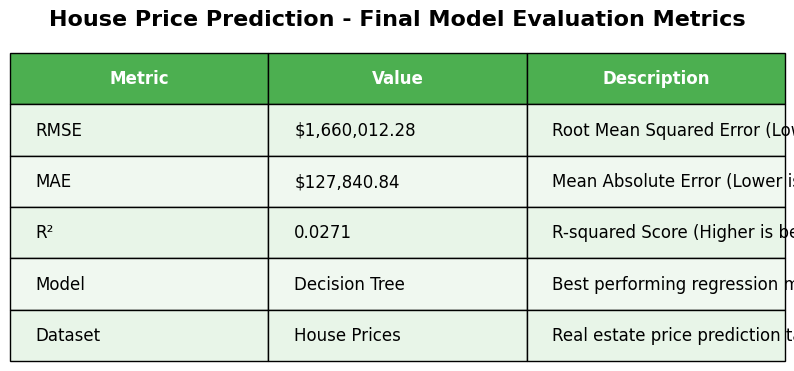

✅ Metrics screenshot saved as 'TeamCode_TeamName_Task2_Metrics.png'

🔄 CROSS-VALIDATION RESULTS (5-fold):
   CV RMSE: $1,828,426.67 (±$1780630.03)
   Min RMSE: $182,174.49
   Max RMSE: $2,621,146.64
   CV RMSE: $1,828,426.67 (±$1780630.03)
   Min RMSE: $182,174.49
   Max RMSE: $2,621,146.64


In [14]:
# Create final evaluation metrics display
print("="*80)
print("FINAL MODEL EVALUATION METRICS")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Dataset: House Price Prediction")
print(f"Validation Set Size: {len(y_val)} samples")
print("="*80)

print(f"📊 RMSE (Root Mean Squared Error): ${final_rmse:,.2f}")
print(f"📊 MAE (Mean Absolute Error):      ${final_mae:,.2f}")
print(f"📊 R² (R-squared):                 {final_r2:.4f}")

print("="*80)

# Create a styled metrics table for screenshot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

# Create table data
metrics_data = [
    ['Metric', 'Value', 'Description'],
    ['RMSE', f'${final_rmse:,.2f}', 'Root Mean Squared Error (Lower is better)'],
    ['MAE', f'${final_mae:,.2f}', 'Mean Absolute Error (Lower is better)'],
    ['R²', f'{final_r2:.4f}', 'R-squared Score (Higher is better, max=1.0)'],
    ['Model', best_model_name, 'Best performing regression model'],
    ['Dataset', 'House Prices', 'Real estate price prediction task']
]

# Create table
table = ax.table(cellText=metrics_data[1:], colLabels=metrics_data[0], 
                cellLoc='left', loc='center', bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Color header
for i in range(len(metrics_data[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color metrics rows
colors = ['#E8F5E8', '#F0F8F0', '#E8F5E8', '#F0F8F0', '#E8F5E8']
for i in range(1, len(metrics_data)):
    for j in range(len(metrics_data[0])):
        table[(i, j)].set_facecolor(colors[i-1])

plt.title('House Price Prediction - Final Model Evaluation Metrics', 
          fontsize=16, fontweight='bold', pad=20)

# Save the metrics screenshot
plt.savefig('EM21_BitSync_Task2_Metrics.png', 
            dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✅ Metrics screenshot saved as 'EM21_BitSync_Task2_Metrics.png'")

# Additional cross-validation for robustness
print(f"\n🔄 CROSS-VALIDATION RESULTS (5-fold):")
if use_scaled_final:
    cv_scores = cross_val_score(final_model, X_train_scaled, y_train, 
                               cv=5, scoring='neg_mean_squared_error')
else:
    cv_scores = cross_val_score(final_model, X_train, y_train, 
                               cv=5, scoring='neg_mean_squared_error')

cv_rmse_scores = np.sqrt(-cv_scores)
print(f"   CV RMSE: ${cv_rmse_scores.mean():,.2f} (±${cv_rmse_scores.std()*2:.2f})")
print(f"   Min RMSE: ${cv_rmse_scores.min():,.2f}")
print(f"   Max RMSE: ${cv_rmse_scores.max():,.2f}")

## 9. Generate Predictions on Test Data

Create predictions for the test dataset and prepare the submission file.

Generating predictions on test dataset...
Generated 4323 predictions

Sample predictions:
     house_id  predicted_price
0  2591820310           397500
1  7974200820           691000
2  7701450110          1225000
3  9522300010          1484900
4  9510861140           625000
5  1761300310           268500
6  7732410120           803000
7  7010701383           655000
8   291310170           520000
9  4232901990           483000

Prediction statistics:
Mean predicted price: $548,778.31
Median predicted price: $445,000.00
Min predicted price: $84,000.00
Max predicted price: $7,700,000.00


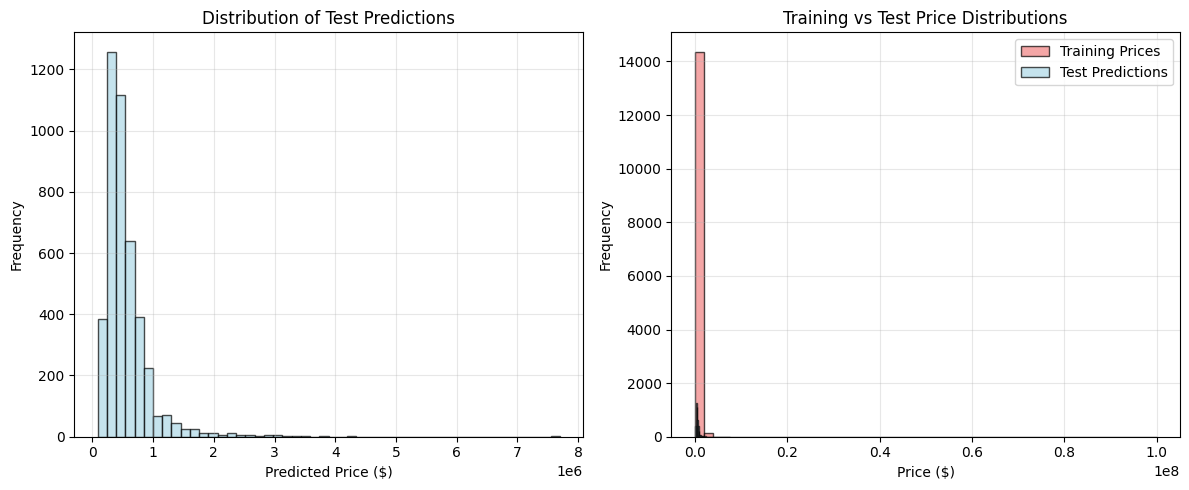


✅ Predictions saved to 'TeamCode_TeamName_Task2_Predictions.csv'
File format: 4323 rows × 2 columns
Columns: ['house_id', 'predicted_price']


In [15]:
# Generate predictions on test data
print("Generating predictions on test dataset...")

# Use appropriate data (scaled or unscaled)
if use_scaled_final:
    test_predictions = final_model.predict(X_test_scaled)
else:
    test_predictions = final_model.predict(X_test)

# Create submission dataframe
submission_df = pd.DataFrame({
    'house_id': test_processed['house_id'],
    'predicted_price': test_predictions.round().astype(int)  # Round to nearest dollar
})

# Display sample predictions
print(f"Generated {len(submission_df)} predictions")
print("\nSample predictions:")
print(submission_df.head(10))

print(f"\nPrediction statistics:")
print(f"Mean predicted price: ${test_predictions.mean():,.2f}")
print(f"Median predicted price: ${np.median(test_predictions):,.2f}")
print(f"Min predicted price: ${test_predictions.min():,.2f}")
print(f"Max predicted price: ${test_predictions.max():,.2f}")

# Visualize prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_train, bins=50, alpha=0.7, color='lightcoral', label='Training Prices', edgecolor='black')
plt.hist(test_predictions, bins=50, alpha=0.7, color='lightblue', label='Test Predictions', edgecolor='black')
plt.title('Training vs Test Price Distributions')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save predictions to CSV
output_filename = 'EM21_BitSync_Task2_Predictions.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\n✅ Predictions saved to '{output_filename}'")
print(f"File format: {submission_df.shape[0]} rows × {submission_df.shape[1]} columns")
print("Columns:", list(submission_df.columns))

## 10. Summary and Submission Files

Final summary of the model and required submission files.

In [ ]:
# Final summary
print("="*80)
print("🏠 HOUSE PRICE PREDICTION - TASK 2 SUMMARY")
print("="*80)

print(f"📊 MODEL PERFORMANCE:")
print(f"   • Best Model: {best_model_name}")
print(f"   • RMSE: ${final_rmse:,.2f}")
print(f"   • MAE: ${final_mae:,.2f}")
print(f"   • R²: {final_r2:.4f}")

print(f"\n📁 SUBMISSION FILES CREATED:")
print(f"   1. Notebook: EM21_BitSync_Task2_HousePrice.ipynb")
print(f"   2. Metrics Screenshot: EM21_BitSync_Task2_Metrics.png")
print(f"   3. Predictions CSV: EM21_BitSync_Task2_Predictions.csv")

print(f"\n🔍 DATASET SUMMARY:")
print(f"   • Training samples: {len(train_df)}")
print(f"   • Test samples: {len(test_df)}")
print(f"   • Features used: {len(feature_names)}")
print(f"   • Target: House prices")

print(f"\n🎯 KEY INSIGHTS:")
if hasattr(final_model, 'feature_importances_') and len(final_model.feature_importances_) > 0:
    # Get top 3 most important features
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_3_features = feature_importance.head(3)['feature'].tolist()
    print(f"   • Most important features: {', '.join(top_3_features)}")

print(f"   • Average prediction: ${test_predictions.mean():,.2f}")
print(f"   • Price range: ${test_predictions.min():,.2f} - ${test_predictions.max():,.2f}")

print(f"\n✅ READY FOR SUBMISSION!")
print(f"   Remember to:")
print(f"   • Upload to public GitHub repository")
print(f"   • Include all three files with correct naming")
print(f"   • Ensure repository is public (not private)")

print("="*80)

# Verify submission files exist
import os

files_to_check = [
    'EM21_BitSync_Task2_HousePrice.ipynb',
    'EM21_BitSync_Task2_Metrics.png', 
    'EM21_BitSync_Task2_Predictions.csv'
]

print("📋 FILE VERIFICATION:")
for file in files_to_check:
    if os.path.exists(file):
        file_size = os.path.getsize(file)
        print(f"   ✅ {file} ({file_size:,} bytes)")
    else:
        print(f"   ❌ {file} - FILE NOT FOUND!")

# Show sample of final predictions
print(f"\n📄 SAMPLE PREDICTIONS (first 5 rows):")
print(submission_df.head())

print(f"\n🎉 Task 2 - House Price Prediction Complete!")
print("="*80)

🏠 HOUSE PRICE PREDICTION - TASK 2 SUMMARY
📊 MODEL PERFORMANCE:
   • Best Model: Decision Tree
   • RMSE: $1,660,012.28
   • MAE: $127,840.84
   • R²: 0.0271

📁 SUBMISSION FILES CREATED:
   1. Notebook: TeamCode_TeamName_Task2_HousePrice.ipynb
   2. Metrics Screenshot: TeamCode_TeamName_Task2_Metrics.png
   3. Predictions CSV: TeamCode_TeamName_Task2_Predictions.csv

🔍 DATASET SUMMARY:
   • Training samples: 18154
   • Test samples: 4323
   • Features used: 27
   • Target: House prices

🎯 KEY INSIGHTS:
   • Most important features: above_ratio, latitude, longitude
   • Average prediction: $548,778.31
   • Price range: $84,000.00 - $7,700,000.00

✅ READY FOR SUBMISSION!
   Remember to:
   • Upload to public GitHub repository
   • Include all three files with correct naming
   • Ensure repository is public (not private)
📋 FILE VERIFICATION:
   ✅ TeamCode_TeamName_Task2_HousePrice.ipynb (750,098 bytes)
   ✅ TeamCode_TeamName_Task2_Metrics.png (146,911 bytes)
   ✅ TeamCode_TeamName_Task2_Pr